In [2]:
import etl_eda
import importlib
importlib.reload(etl_eda)
from etl_eda import *
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import kstest, normaltest, spearmanr
from sklearn.preprocessing import StandardScaler, LabelEncoder

In [3]:
df_train = load('train.csv')
df_item_categories = load('item_categories.csv')
df_shops = load('shops.csv')
df_items  = load('items.csv')

In [4]:
df_train[['item_cnt_month', 'item_price']].describe().map(lambda x: f"{x:0.1f}")

,item_cnt_month,item_price
count,42474228.0,42474228.0
mean,0.1,30.0
std,1.7,334.3
min,-22.0,0.0
25%,0.0,0.0
50%,0.0,0.0
75%,0.0,0.0
max,1644.0,50999.0


ITEM_CNT_MONTH

In [5]:
df_train.loc[df_train['item_cnt_month'] < 0, 'item_cnt_month'].count()

np.int64(915)

Item_cnt_month must be positive

In [6]:
df_train.loc[df_train['item_cnt_month'] < 0, 'item_cnt_month'] = np.multiply(df_train.loc[df_train['item_cnt_month'] < 0, 'item_cnt_month'],(-1))

Item_cnt_month destribution

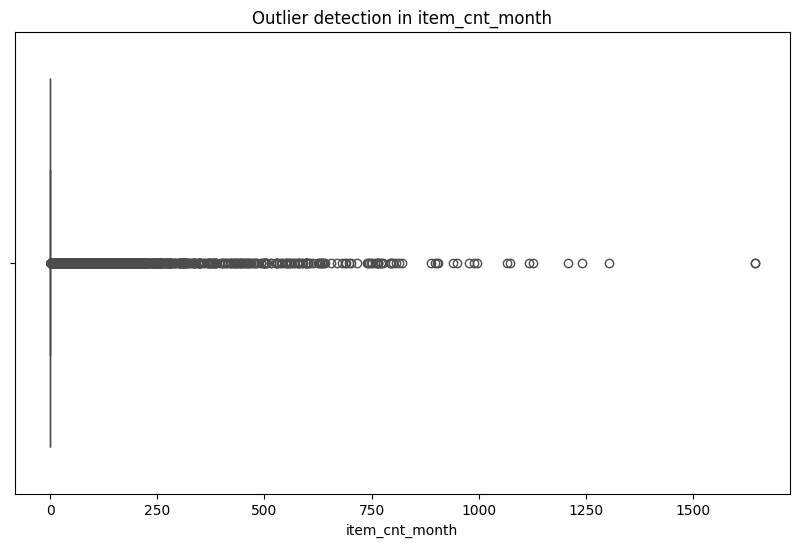

In [7]:
boxplot(df_train, 'item_cnt_month')

Distribution of 'Item_cnt_month' is skewed

Outliers specification

In [8]:
outliers = df_train[df_train.item_cnt_month > 850]

In [9]:
outliers.item_cnt_month.describe().map('{:,.2f}'.format)

count       18.00
mean     1,104.28
std        232.21
min        888.00
25%        943.25
50%      1,031.50
75%      1,188.50
max      1,644.00
Name: item_cnt_month, dtype: object

check of 3 random outliers

In [10]:
check = outliers.sample(n = 3)
outliers_spec(check, 'item_cnt_month', df_item_categories, df_items)

Категория: Билеты (Цифра)
Билет "ИгроМир 2015" - 3 октября 2015 (сайт) УПР [Цифровая версия]
          date_block_num  item_cnt_month
40917119              32          1644.0
Категория: Игры PC - Цифра
Prototype 2 [PC, Цифровая версия]
          date_block_num  item_cnt_month
30970329              24          1127.0
Категория: Подарки - Сумки, Альбомы, Коврики д/мыши
Фирменный пакет майка 1С Интерес белый (34*42) 45 мкм
          date_block_num  item_cnt_month
29087999              23           997.0


Data that looked like outliers correspond to real-world data

Log transformation of 'item_cnt_month' to reduce skewness 

In [11]:
df_train['item_cnt_month_log'] = np.log1p(df_train['item_cnt_month'])

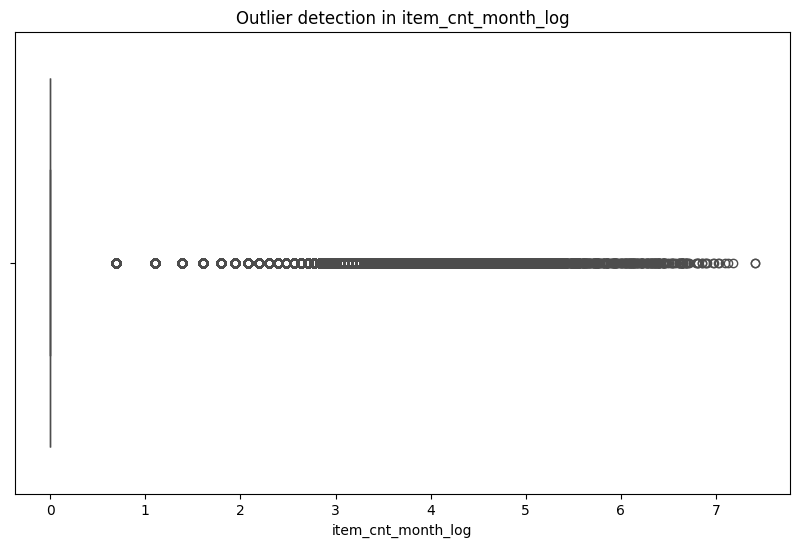

In [12]:
boxplot(df_train, 'item_cnt_month_log')

In [13]:
df_train.item_cnt_month_log.describe().map(lambda x: f"{x:0.3f}")

count    42474228.000
mean            0.036
std             0.206
min             0.000
25%             0.000
50%             0.000
75%             0.000
max             7.405
Name: item_cnt_month_log, dtype: object

ITEM_CNT_MONTH

In [14]:
df_train[df_train.item_price < 0]

,date_block_num,shop_id,item_id,item_cnt_month,item_price,item_cnt_month_log


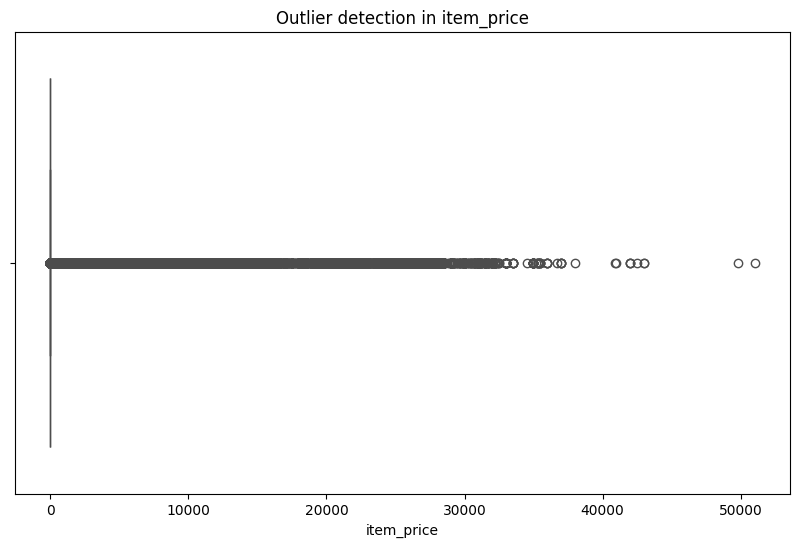

In [15]:
boxplot(df_train, "item_price")

In [16]:
outliers = df_train[df_train.item_price > 33000]
outliers.item_price.describe().map('{:,.2f}'.format)

count        47.00
mean     37,110.08
std       3,931.42
min      33,490.00
25%      34,990.00
50%      35,490.00
75%      36,990.00
max      50,999.00
Name: item_price, dtype: object

In [17]:
check = outliers.sample(n = 3)
outliers_spec(check, 'item_price', df_item_categories, df_items)

Категория: Игровые консоли - XBOX ONE
Комплект "Microsoft Xbox One 1TB  (CoD:AW) + "Call of Duty: Advanced Warfare" + "Xbox LIVE Gold 14 дн." [5C7-00013]
          date_block_num  item_price
32416869              26     33490.0
Категория: Игровые консоли - PS4
Комплект Sony PlayStation 4 (1Tb) Black (CUH-1208B) + игра Uncharted: Натан Дрейк. Коллекция
          date_block_num  item_price
41313760              33     34990.0


Data that looked like outliers correspond to real-world data

Log transformation of 'item_price' to reduce skewness 

In [18]:
df_train['item_price_log'] = np.log1p(df_train['item_price'])

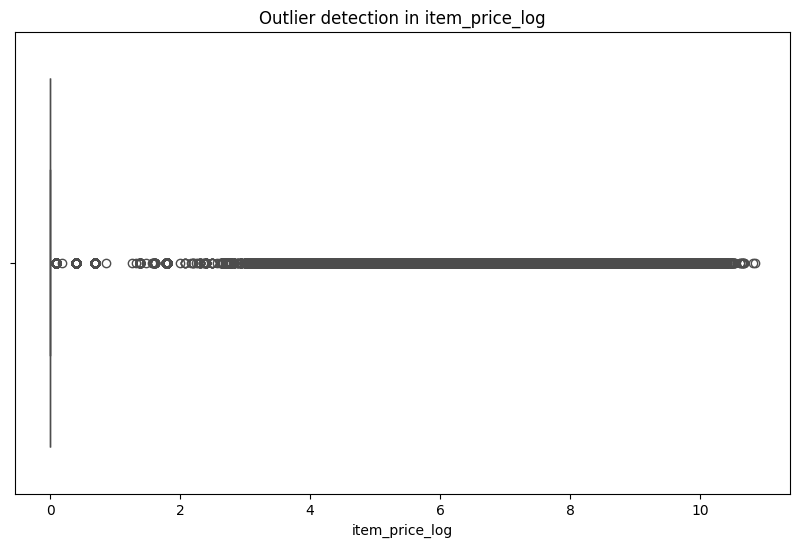

In [19]:
boxplot(df_train, 'item_price_log')

In [20]:
df_train.item_price_log.describe().map(lambda x: f"{x:0.3f}")

count    42474228.000
mean            0.230
std             1.177
min             0.000
25%             0.000
50%             0.000
75%             0.000
max            10.840
Name: item_price_log, dtype: object

Item_cnt_month behavior during the analyzed period

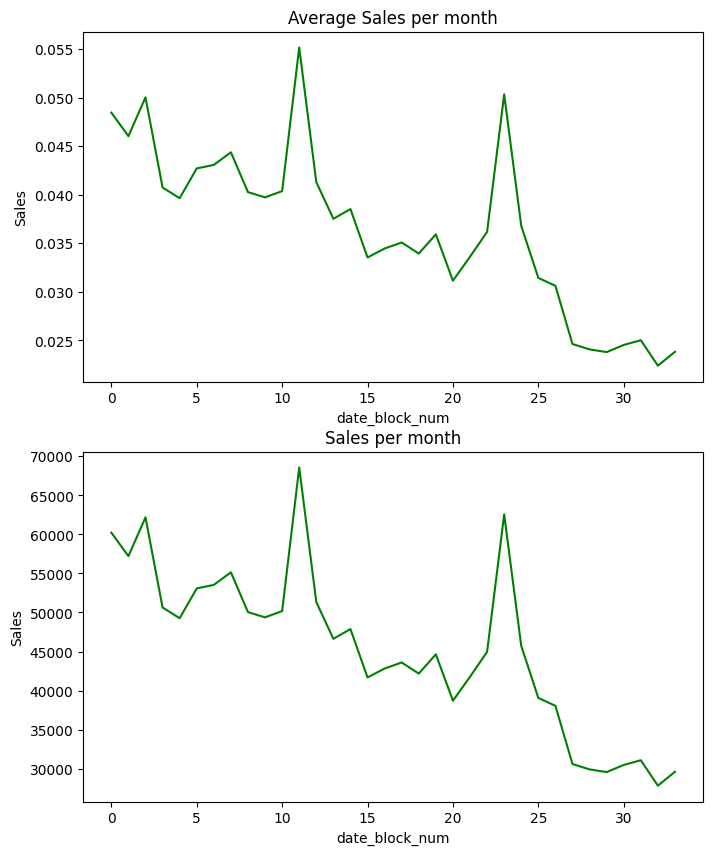

In [21]:
figure, ax = plt.subplots(2, 1, figsize = (8,10))

sns.lineplot(data = df_train.loc[df_train['date_block_num'] < 34].groupby('date_block_num').agg({'item_cnt_month_log': 'mean'}), x = 'date_block_num', y = 'item_cnt_month_log', c = 'g', ax = ax[0]).set_title('Average Sales per month')

sns.lineplot(data = df_train.loc[df_train['date_block_num'] < 34].groupby('date_block_num').agg({'item_cnt_month_log': 'sum'}), x = 'date_block_num', y = 'item_cnt_month_log', c = 'g', ax = ax[1]).set_title('Sales per month')

ax[0].set_ylabel('Sales')
ax[1].set_ylabel('Sales')

plt.show()

Sales are seasonal and decline during the analysed period

Time-influenced features engineering

In [22]:
group = df_train.groupby('date_block_num').agg({'item_cnt_month_log':['sum', 'mean']})
group = group.reset_index()
group['date'] = pd.date_range(start='2013-01-01', periods=35, freq='ME')
group['month'] = group['date'].dt.month
group['year'] = group['date'].dt.year
group.head()

date_block_num item_cnt_month_log                 date month  year
                                sum      mean                       
0              0       60214.853279  0.048445 2013-01-31     1  2013
1              1       57211.057757  0.046029 2013-02-28     2  2013
2              2       62174.577721  0.050022 2013-03-31     3  2013
3              3       50636.383487  0.040739 2013-04-30     4  2013
4              4       49261.175075  0.039633 2013-05-31     5  2013

Item_cnt_month behavior during the year

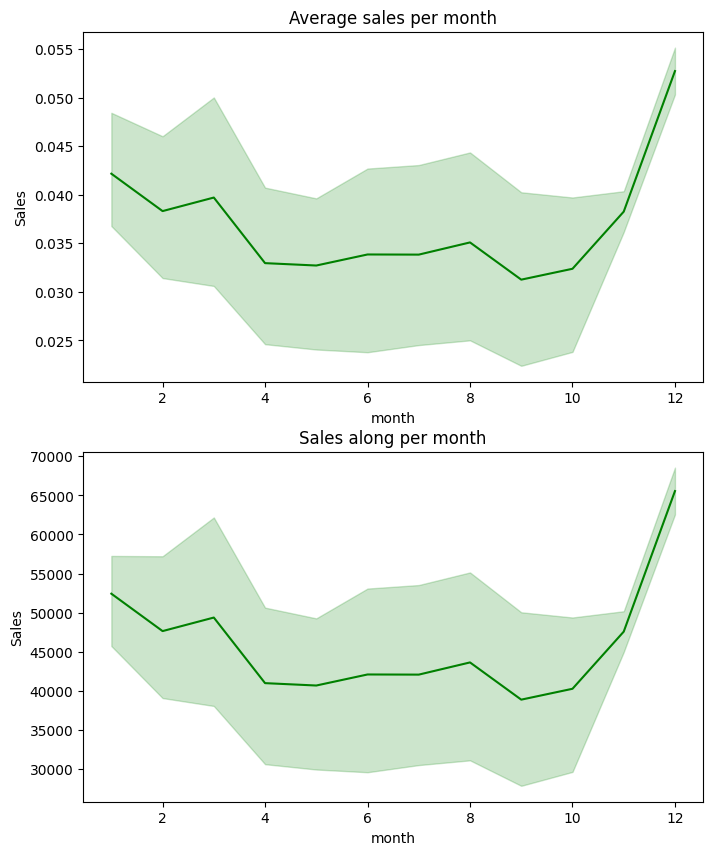

In [23]:
figure, ax = plt.subplots(2, 1, figsize = (8,10))

sns.lineplot(data = group.loc[group['date_block_num'] < 34], x = 'month', y = ('item_cnt_month_log', 'mean'), c = 'g', ax = ax[0]).set_title('Average sales per month')

sns.lineplot(data = group.loc[group['date_block_num'] < 34], x = 'month', y = ('item_cnt_month_log', 'sum'), c = 'g', ax = ax[1]).set_title('Sales along per month')

ax[0].set_ylabel('Sales')
ax[1].set_ylabel('Sales')

plt.show()

Item sales are incresing toward the ending of the year

Item_cnt_month behavior during the analyzed period

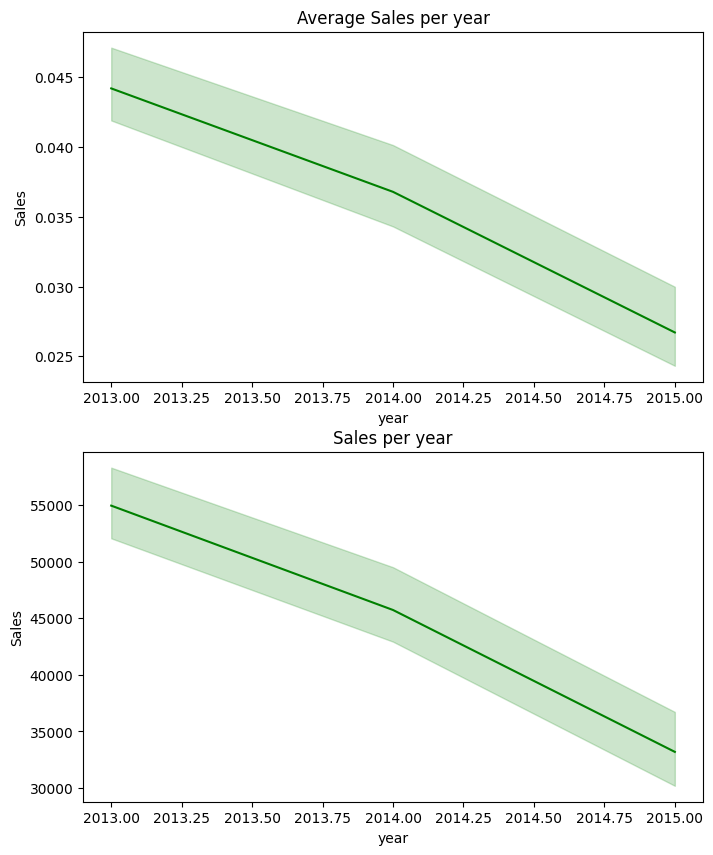

In [24]:
figure, ax = plt.subplots(2, 1, figsize = (8,10))

sns.lineplot(data = group.loc[group['date_block_num'] < 34], x = 'year', y = ('item_cnt_month_log', 'mean'), c = 'g', ax = ax[0]).set_title('Average Sales per year')

sns.lineplot(data = group.loc[group['date_block_num'] < 34], x = 'year', y = ('item_cnt_month_log', 'sum'), c = 'g', ax = ax[1]).set_title('Sales per year')

ax[0].set_ylabel('Sales')
ax[1].set_ylabel('Sales')

plt.show()

decline during the analysed period

As we have correlation of new features 'month' and 'year' with our target, it will be reasonable to add them in our df

In [25]:
group = group.droplevel(1, axis=1)[['date_block_num', 'month', 'year']]

In [26]:
df_train = pd.merge(df_train, group, on = 'date_block_num', how = 'left')

In [27]:
df_train.head(2)

,date_block_num,shop_id,item_id,item_cnt_month,item_price,item_cnt_month_log,item_price_log,month,year
0,0,2,0,0.0,0.0,0.0,0.0,1,2013
1,0,2,1,0.0,0.0,0.0,0.0,1,2013


Shop_id - target dependence

In [28]:
encoder = LabelEncoder()

In [29]:
group = df_train.groupby('shop_id').agg({'item_cnt_month_log':'sum'}).reset_index()
group['shop_id_encoded'] = encoder.fit_transform(group['shop_id'])
group = pd.merge(group, df_shops, on = 'shop_id', how = 'left')
sorted_group = group.groupby('shop_name').agg({'item_cnt_month_log':'sum'}).sort_values(by = 'item_cnt_month_log', ascending = False).reset_index()
sorted_group.head()

,shop_name,item_cnt_month_log
0,"Москва ТЦ ""Семеновский""",108581.873027
1,"Москва ТРК ""Атриум""",90822.427482
2,"Химки ТЦ ""Мега""",71203.536226
3,"Москва ТЦ ""МЕГА Теплый Стан"" II",68059.530870
4,"Якутск Орджоникидзе, 56",64104.077573


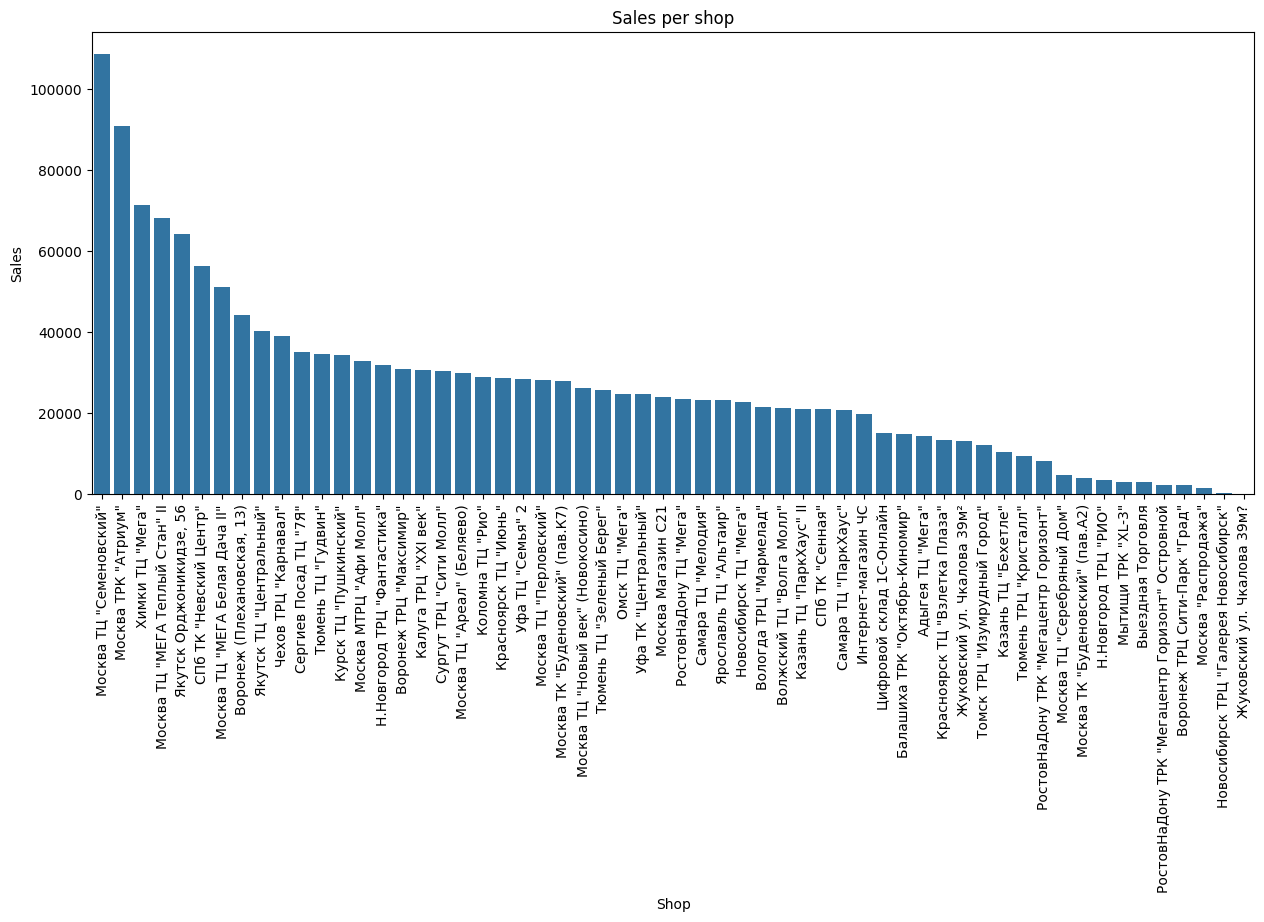

In [30]:
plt.figure(figsize = (15,6))

sns.barplot(x = sorted_group['shop_name'], y = sorted_group['item_cnt_month_log'])

plt.title('Sales per shop')
plt.xlabel('Shop')
plt.ylabel('Sales')

plt.xticks(rotation=90)
plt.show()

Sales depend on the type of shop and it's location. Shops in big cities takes the biggest part. Mostly people buy offline, sales through an online shop are inferior.

In [31]:
df_train['shop_id_encoded'] = encoder.fit_transform(df_train['shop_id'])

In [32]:
samples = df_train.shop_id_encoded.sample(3).values

Tendencies in full period of time

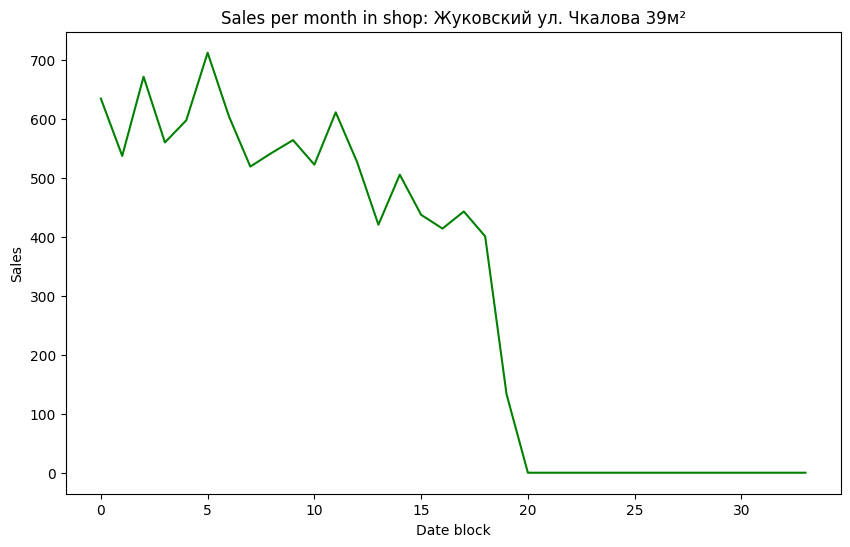

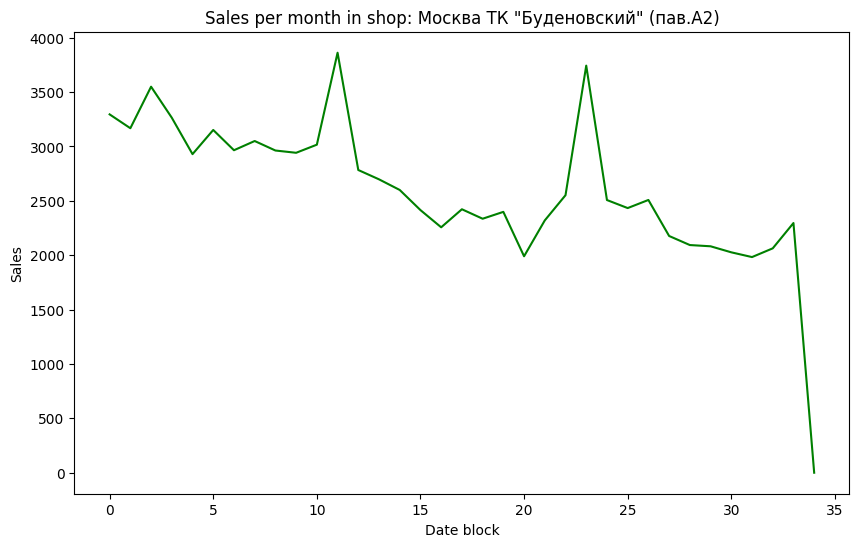

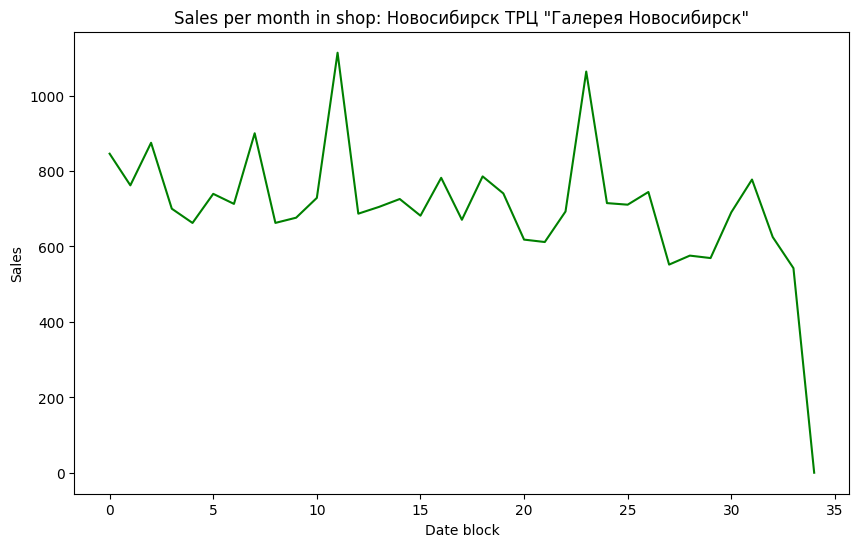

In [38]:
for s in samples:
    plt.figure(figsize = (10,6))

    sns.lineplot(data = df_train.loc[df_train['shop_id_encoded'] == s].groupby('date_block_num').agg({'item_cnt_month_log': 'sum'}), x = 'date_block_num', y = 'item_cnt_month_log', c = 'g')
    plt.title(f'Sales per month in shop: {df_shops[df_shops.shop_id == s]['shop_name'].values[0]}')
    plt.xlabel('Date block')
    plt.ylabel('Sales')
    plt.show()

They are similar to the general picture. For some shops we don't have full range of data

Tendencies during the year

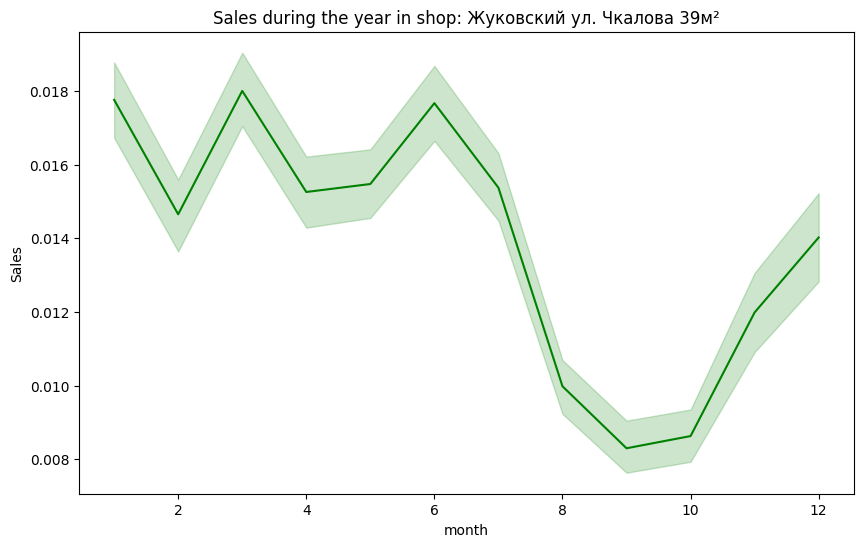

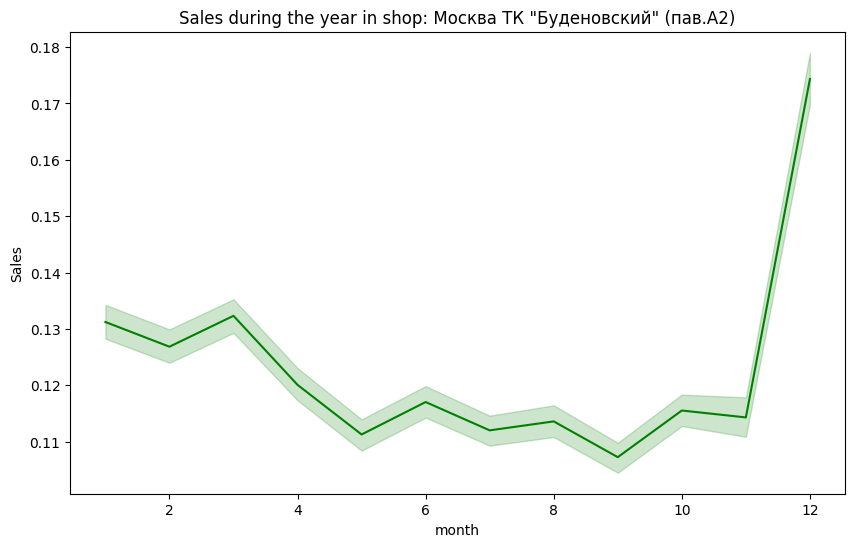

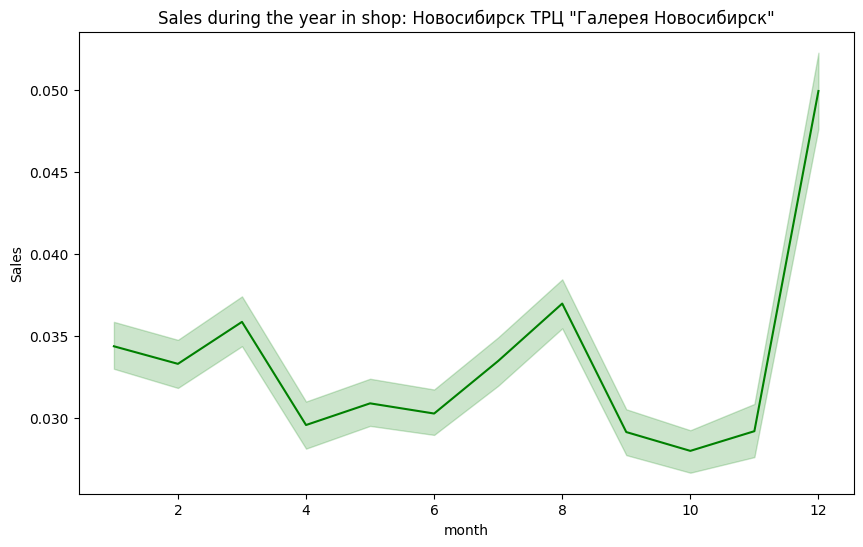

In [39]:
for s in samples:
    plt.figure(figsize = (10,6))

    sns.lineplot(data = df_train.loc[df_train['shop_id_encoded'] == s], x = 'month', y = 'item_cnt_month_log', c = 'g')
    plt.title(f'Sales during the year in shop: {df_shops[df_shops.shop_id == s]['shop_name'].values[0]}')
    plt.xlabel('month')
    plt.ylabel('Sales')
    plt.show()

Sales at the beggining of the year are vary from shop to shop. But an increase in sales towards the end of the year is common.

New feature: city

In [40]:
df_shops['city'] = df_shops['shop_name'].str.split(' ').apply(lambda x: x[0])
df_shops['city_id'] = encoder.fit_transform(df_shops['city'])
df_shops['shop_id_encoded'] = encoder.fit_transform(df_shops['shop_id'])
df_shops.head()

,shop_name,shop_id,city,city_id,shop_id_encoded
0,"Якутск Орджоникидзе, 56 фран",0,Якутск,29,0
1,"Якутск ТЦ ""Центральный"" фран",1,Якутск,29,1
2,"Адыгея ТЦ ""Мега""",2,Адыгея,0,2
3,"Балашиха ТРК ""Октябрь-Киномир""",3,Балашиха,1,3
4,"Волжский ТЦ ""Волга Молл""",4,Волжский,2,4


In [41]:
group = df_train.groupby('shop_id_encoded').agg({'item_cnt_month_log':'sum'})
group = group.reset_index()
group = pd.merge(group, df_shops, on = 'shop_id_encoded', how = 'left')
sorted_group = group.groupby('city').agg({'item_cnt_month_log':'sum'}).sort_values(by = 'item_cnt_month_log', ascending = False).reset_index()
sorted_group.head()

,city,item_cnt_month_log
0,Москва,469133.539497
1,РостовНаДону,100294.631300
2,Уфа,86138.582806
3,Тюмень,78559.128323
4,Самара,65229.095548


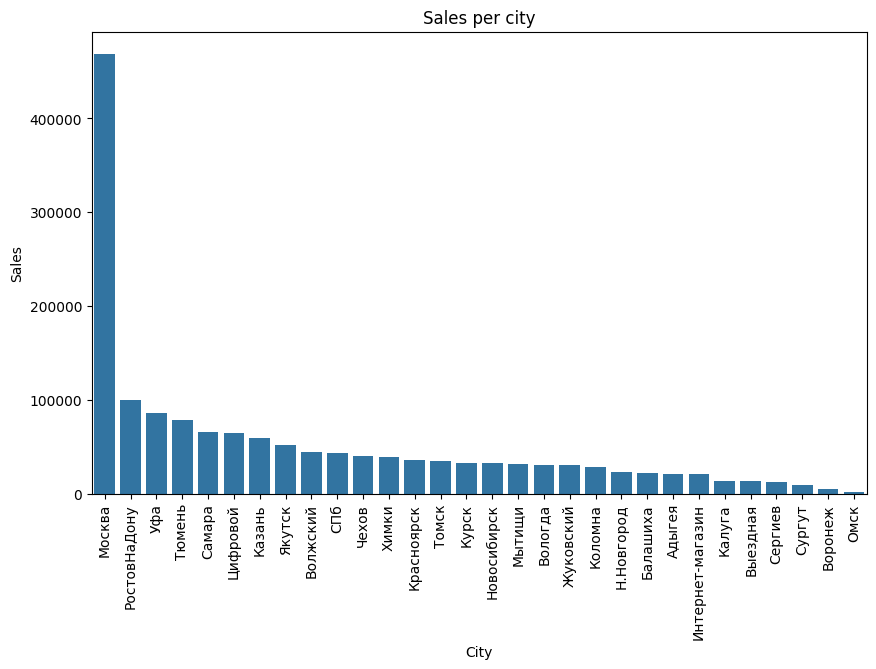

In [42]:
plt.figure(figsize=(10,6))

sns.barplot(x = sorted_group['city'], y = sorted_group['item_cnt_month_log'])

plt.title('Sales per city')
plt.ylabel('Sales')
plt.xlabel('City')
plt.xticks(rotation=90)

plt.show()

Sales are higher in big cities. The highest sales are observed in the capital of the country - Moscow. Mostly people buy offline, sales through an online shop are inferior.

In [43]:
group = group[['shop_id_encoded', 'city_id']]
group.head()

,shop_id_encoded,city_id
0,0,29
1,1,29
2,2,0
3,3,1
4,4,2


In [44]:
df_train = pd.merge(df_train, group, on = 'shop_id_encoded', how = 'left')
df_train.head()

,date_block_num,shop_id,item_id,item_cnt_month,item_price,item_cnt_month_log,item_price_log,month,year,shop_id_encoded,city_id
0,0,2,0,0.0,0.0,0.0,0.0,1,2013,0,29
1,0,2,1,0.0,0.0,0.0,0.0,1,2013,0,29
2,0,2,2,0.0,0.0,0.0,0.0,1,2013,0,29
3,0,2,3,0.0,0.0,0.0,0.0,1,2013,0,29
4,0,2,4,0.0,0.0,0.0,0.0,1,2013,0,29


In [45]:
samples = df_train.city_id.sample(3).values

Time dependecies in full period of time

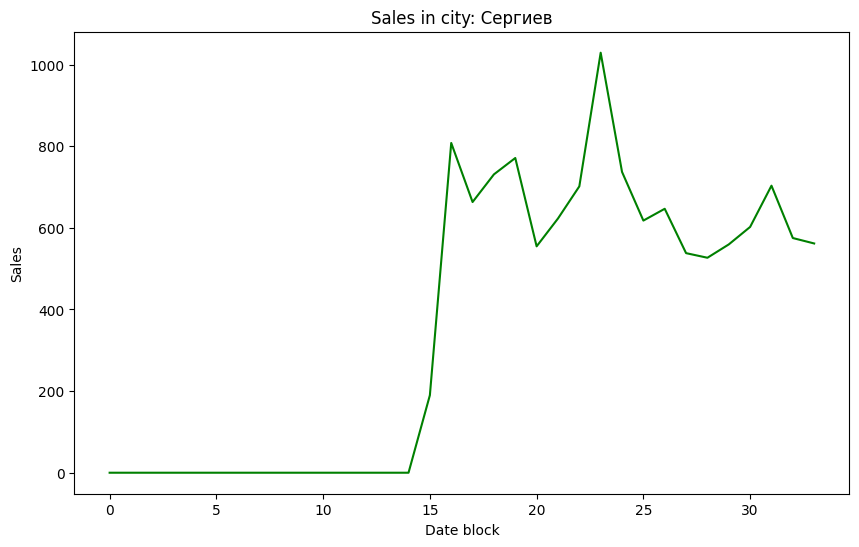

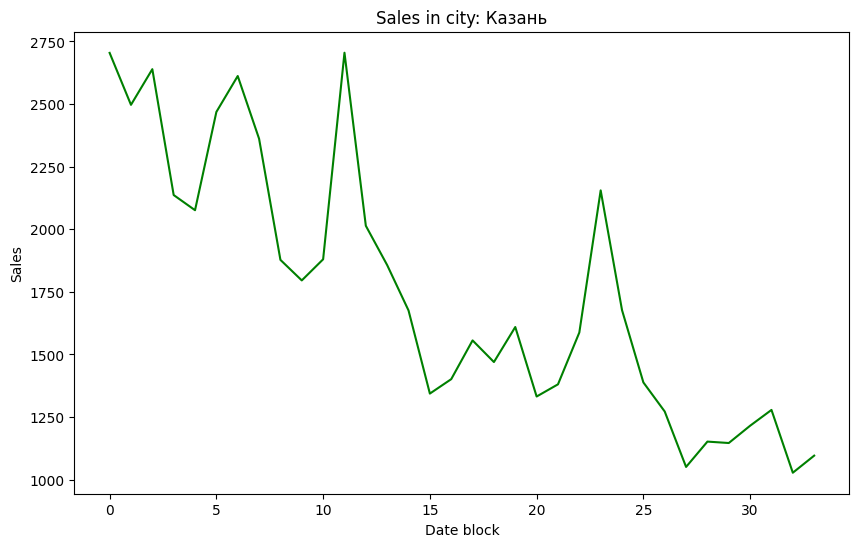

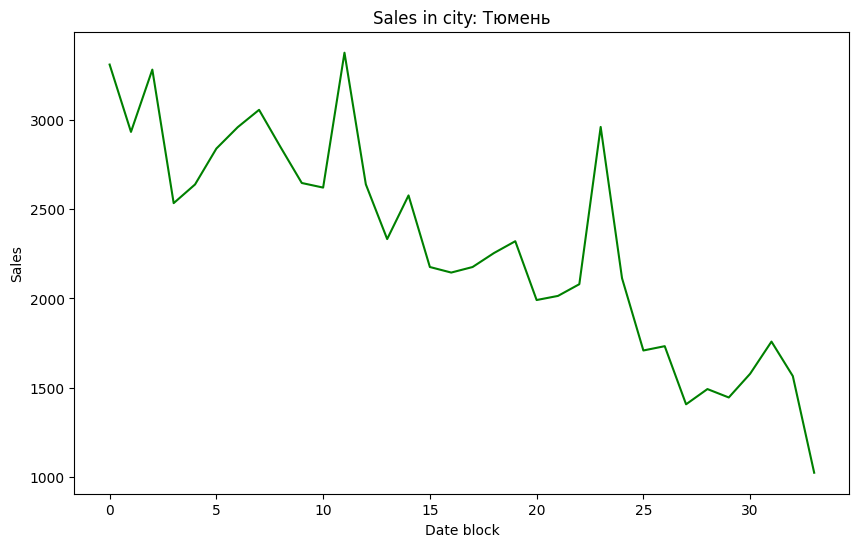

In [46]:
for s in samples:
    plt.figure(figsize = (10,6))

    sns.lineplot(data = df_train.loc[(df_train['city_id'] == s) & (df_train.date_block_num < 34)].groupby('date_block_num').agg({'item_cnt_month_log': 'sum'}), x = 'date_block_num', y = 'item_cnt_month_log', c = 'g')
    plt.title(f'Sales in city: {df_shops[df_shops.city_id == s]['city'].values[0]}')
    plt.xlabel('Date block')
    plt.ylabel('Sales')
    plt.show()

Sales among the cities have similar tendency to decrease during the analysed period

Tendencies during the year

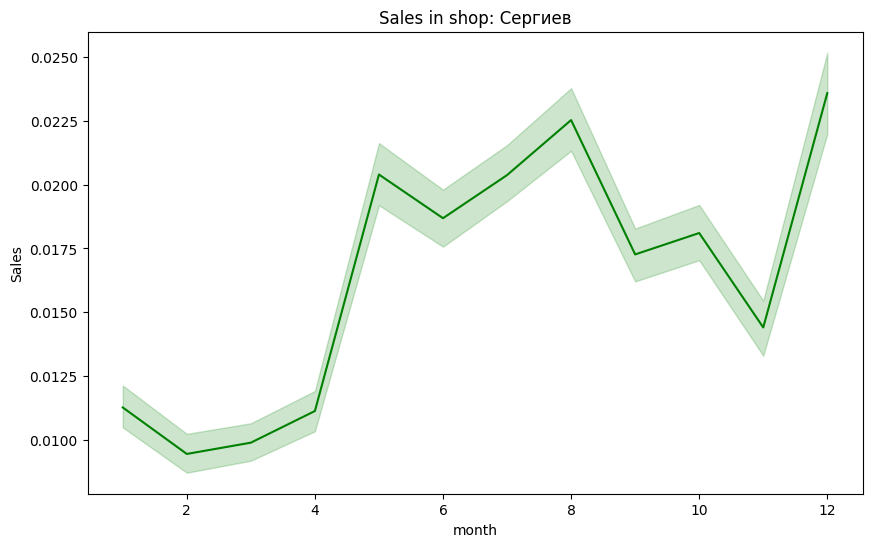

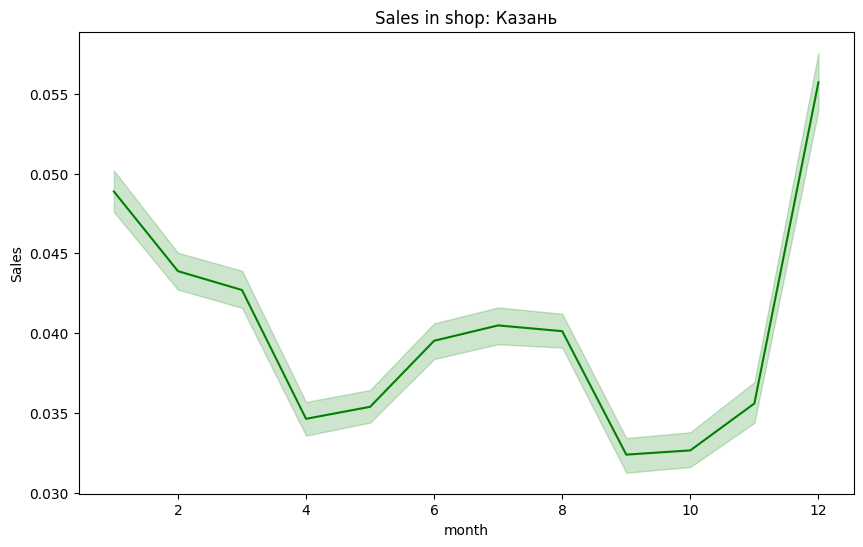

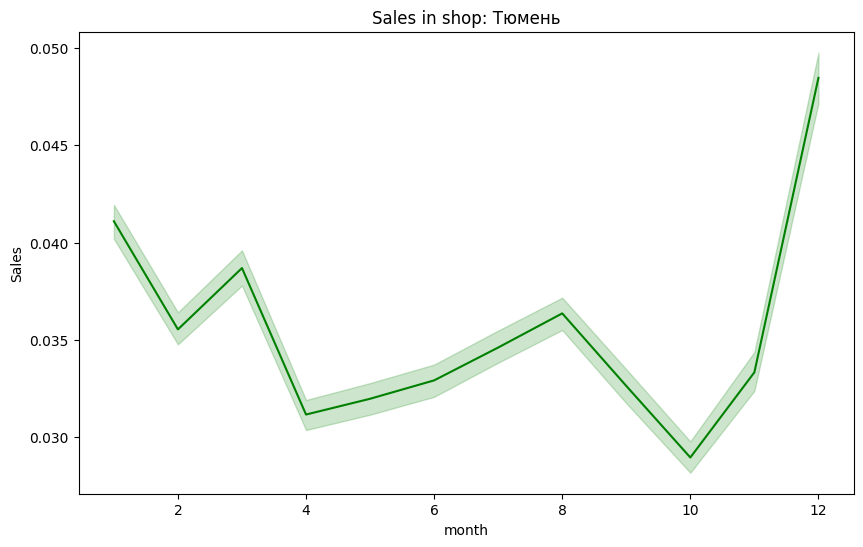

In [47]:
for s in samples:
    plt.figure(figsize = (10,6))

    sns.lineplot(data = df_train.loc[df_train['city_id'] == s], x = 'month', y = 'item_cnt_month_log', c = 'g')
    plt.title(f'Sales in shop: {df_shops[df_shops.city_id == s]['city'].values[0]}')
    plt.xlabel('month')
    plt.ylabel('Sales')
    plt.show()

The trend is similar among the different cities: a slight decrease in sales towards the middle of the year and a noticeable increase towards the end of the year

Item-price dependence

In [48]:
group = df_train.groupby(['date_block_num', 'shop_id', 'item_id']).agg({'item_cnt_month': 'sum', 'item_price': 'mean'}).reset_index()
group = group.groupby('item_price')['item_cnt_month'].sum().reset_index()
group.head()

,item_price,item_cnt_month
0,0.000000,0.0
1,0.090000,5.0
2,0.094000,7.0
3,0.095833,6.0
4,0.100000,3650.0


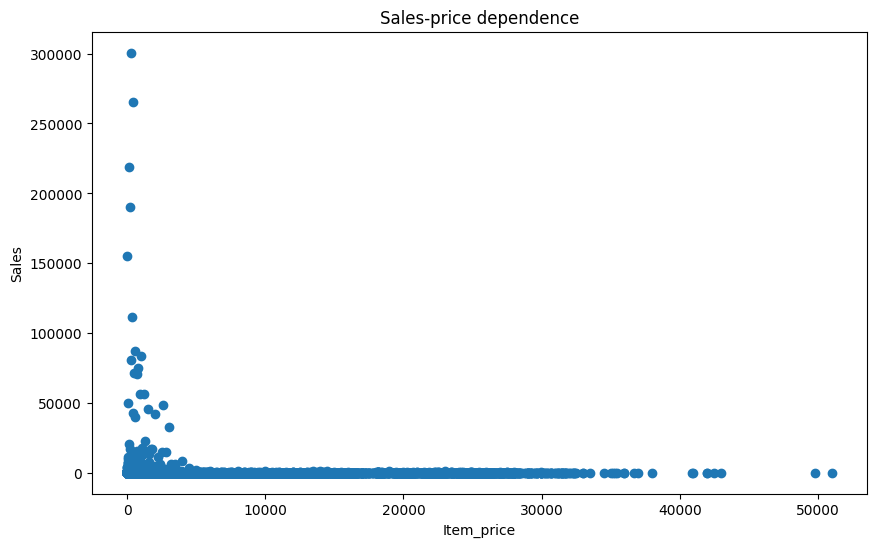

In [49]:
plt.figure(figsize=(10,6))
plt.scatter(x = group['item_price'],
            y = group['item_cnt_month'])

plt.xlabel('Item_price')
plt.ylabel('Sales')
plt.title('Sales-price dependence')

plt.show()

The highest number of sales is observed for the price range from 0 to 33 000. The highest sales we see for the prices lower than 5000.

New feature: revenue (illustration of sales in month dynamics on item_price base)

In [50]:
group = df_train[['item_price', 'item_cnt_month', 'date_block_num', 'shop_id', 'item_cnt_month_log']]
group['revenue'] = (group.item_price * group.item_cnt_month)
group.head()

C:\Users\User\AppData\Local\Temp\ipykernel_23612\3358020166.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group['revenue'] = (group.item_price * group.item_cnt_month)


,item_price,item_cnt_month,date_block_num,shop_id,item_cnt_month_log,revenue
0,0.0,0.0,0,2,0.0,0.0
1,0.0,0.0,0,2,0.0,0.0
2,0.0,0.0,0,2,0.0,0.0
3,0.0,0.0,0,2,0.0,0.0
4,0.0,0.0,0,2,0.0,0.0


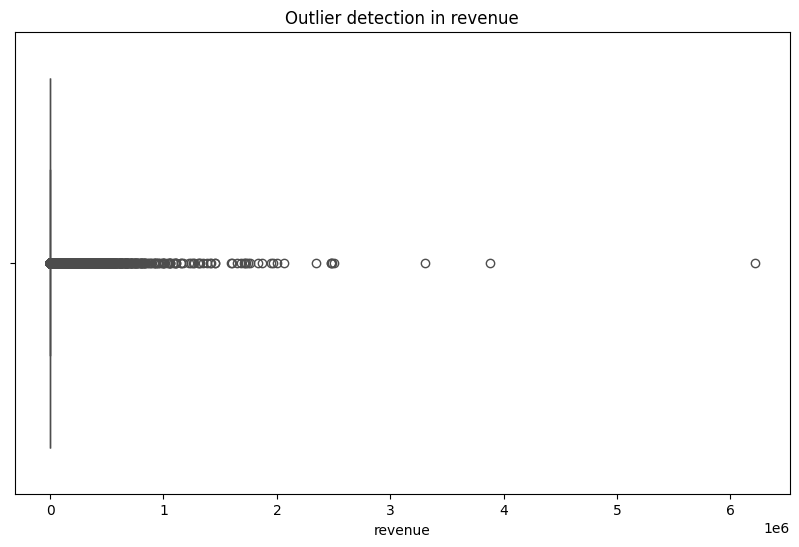

In [51]:
boxplot(group, 'revenue')

In [52]:
group['revenue_log'] = np.log1p(group['revenue'])

C:\Users\User\AppData\Local\Temp\ipykernel_23612\650943199.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group['revenue_log'] = np.log1p(group['revenue'])


In [53]:
df_train['revenue_log'] = np.log1p((df_train.item_price * df_train.item_cnt_month))
df_train.head()

,date_block_num,shop_id,item_id,item_cnt_month,item_price,item_cnt_month_log,item_price_log,month,year,shop_id_encoded,city_id,revenue_log
0,0,2,0,0.0,0.0,0.0,0.0,1,2013,0,29,0.0
1,0,2,1,0.0,0.0,0.0,0.0,1,2013,0,29,0.0
2,0,2,2,0.0,0.0,0.0,0.0,1,2013,0,29,0.0
3,0,2,3,0.0,0.0,0.0,0.0,1,2013,0,29,0.0
4,0,2,4,0.0,0.0,0.0,0.0,1,2013,0,29,0.0


In [54]:
df_items = df_items[['item_id', 'item_category_id']]
df_train = pd.merge(df_train, df_items, on = 'item_id', how = 'left')
df_train.head()

,date_block_num,shop_id,item_id,item_cnt_month,item_price,item_cnt_month_log,item_price_log,month,year,shop_id_encoded,city_id,revenue_log,item_category_id
0,0,2,0,0.0,0.0,0.0,0.0,1,2013,0,29,0.0,40
1,0,2,1,0.0,0.0,0.0,0.0,1,2013,0,29,0.0,76
2,0,2,2,0.0,0.0,0.0,0.0,1,2013,0,29,0.0,40
3,0,2,3,0.0,0.0,0.0,0.0,1,2013,0,29,0.0,40
4,0,2,4,0.0,0.0,0.0,0.0,1,2013,0,29,0.0,40


Item-category_id dependence

In [55]:
df_item_categories.item_category_name.unique()

array(['PC - Гарнитуры/Наушники', 'Аксессуары - PS2', 'Аксессуары - PS3',
       'Аксессуары - PS4', 'Аксессуары - PSP', 'Аксессуары - PSVita',
       'Аксессуары - XBOX 360', 'Аксессуары - XBOX ONE', 'Билеты (Цифра)',
       'Доставка товара', 'Игровые консоли - PS2',
       'Игровые консоли - PS3', 'Игровые консоли - PS4',
       'Игровые консоли - PSP', 'Игровые консоли - PSVita',
       'Игровые консоли - XBOX 360', 'Игровые консоли - XBOX ONE',
       'Игровые консоли - Прочие', 'Игры - PS2', 'Игры - PS3',
       'Игры - PS4', 'Игры - PSP', 'Игры - PSVita', 'Игры - XBOX 360',
       'Игры - XBOX ONE', 'Игры - Аксессуары для игр',
       'Игры Android - Цифра', 'Игры MAC - Цифра',
       'Игры PC - Дополнительные издания',
       'Игры PC - Коллекционные издания', 'Игры PC - Стандартные издания',
       'Игры PC - Цифра', 'Карты оплаты (Кино, Музыка, Игры)',
       'Карты оплаты - Live!', 'Карты оплаты - Live! (Цифра)',
       'Карты оплаты - PSN', 'Карты оплаты - Windows (Цифра)',

categories names we could split inro 2 parts: main category (for most cases 1st word is not a unique one) and minor category

In [61]:
df_item_categories['main_category'] = df_item_categories['item_category_name'].str.split(' - ').apply(lambda x: x[0])
df_item_categories['main_category_id'] = encoder.fit_transform(df_item_categories['main_category'])
df_item_categories['minor_category'] = df_item_categories['item_category_name'].str.split(' - ').apply(lambda x: x[1] if len(x) > 1 else x[0])
df_item_categories['minor_category_id'] = encoder.fit_transform(df_item_categories['minor_category'])
df_item_categories.head()

,item_category_name,item_category_id,main_category,main_category_id,minor_category,minor_category_id
0,PC - Гарнитуры/Наушники,0,PC,0,Гарнитуры/Наушники,31
1,Аксессуары - PS2,1,Аксессуары,1,PS2,11
2,Аксессуары - PS3,2,Аксессуары,1,PS3,12
3,Аксессуары - PS4,3,Аксессуары,1,PS4,13
4,Аксессуары - PSP,4,Аксессуары,1,PSP,15


In [62]:
group = df_train.groupby('item_category_id').agg({'item_cnt_month_log':'sum'}).reset_index()
group = pd.merge(group, df_item_categories, on = 'item_category_id', how = 'left')
group.head()

,item_category_id,item_cnt_month_log,item_category_name,main_category,main_category_id,minor_category,minor_category_id
0,0,2.079442,PC - Гарнитуры/Наушники,PC,0,Гарнитуры/Наушники,31
1,1,1.386294,Аксессуары - PS2,Аксессуары,1,PS2,11
2,2,10004.819108,Аксессуары - PS3,Аксессуары,1,PS3,12
3,3,11127.036427,Аксессуары - PS4,Аксессуары,1,PS4,13
4,4,1280.310889,Аксессуары - PSP,Аксессуары,1,PSP,15


In [63]:
sorted_group = group.groupby('main_category').agg({'item_cnt_month_log':'sum'}).sort_values(by = 'item_cnt_month_log', ascending = False).reset_index()
sorted_group.head()

,main_category,item_cnt_month_log
0,Кино,462424.917885
1,Игры,263087.539997
2,Музыка,242792.957407
3,Игры PC,228791.311209
4,Подарки,196396.747596


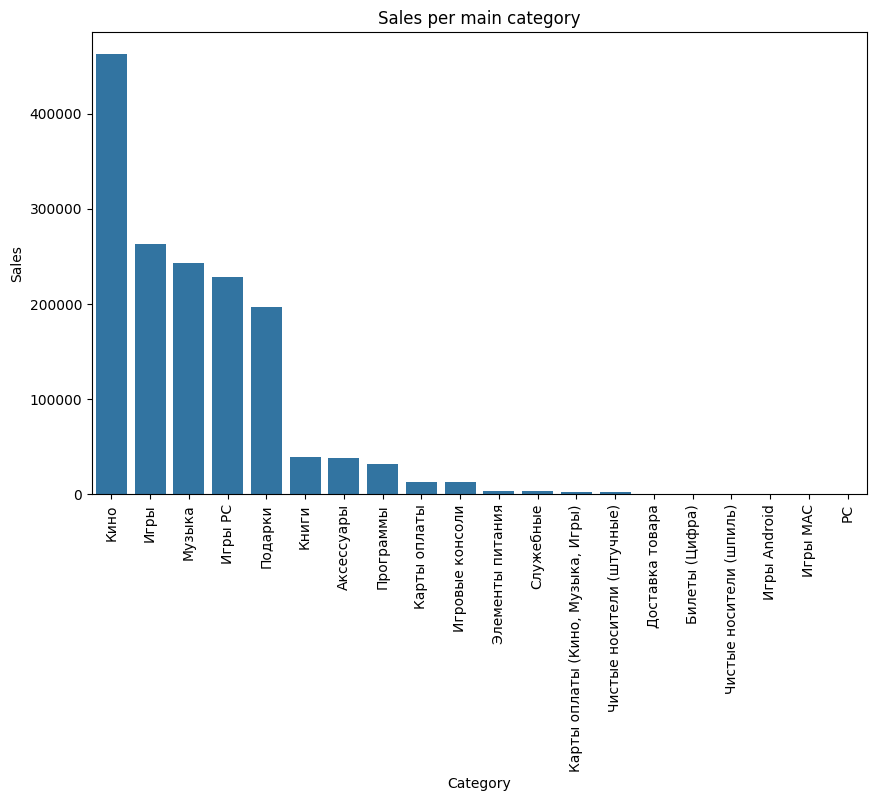

In [65]:
plt.figure(figsize = (10,6))

sns.barplot(x = sorted_group['main_category'], y = sorted_group['item_cnt_month_log'])

plt.title('Sales per main category')
plt.xlabel('Category')
plt.ylabel('Sales')

plt.xticks(rotation=90)
plt.show()

Main category: the highest sales are in the 'Кино' category. The smallest - 'PC'. We have the category 'Игры' that is introduced in different subsets - the lowest sales are observed for Android and MAC games. Sales of PCs and other devices are approximately the same.

In [99]:
sorted_group = group.groupby(['main_category', 'minor_category']).agg({'item_cnt_month_log':'sum'}).sort_values(by = 'item_cnt_month_log', ascending = False).reset_index()
sorted_group.head()

,main_category,minor_category,item_cnt_month_log
0,Кино,DVD,303651.541150
1,Музыка,CD локального производства,203801.754277
2,Игры PC,Стандартные издания,158083.559621
3,Кино,Blu-Ray,112906.653587
4,Игры,PS3,102498.721970


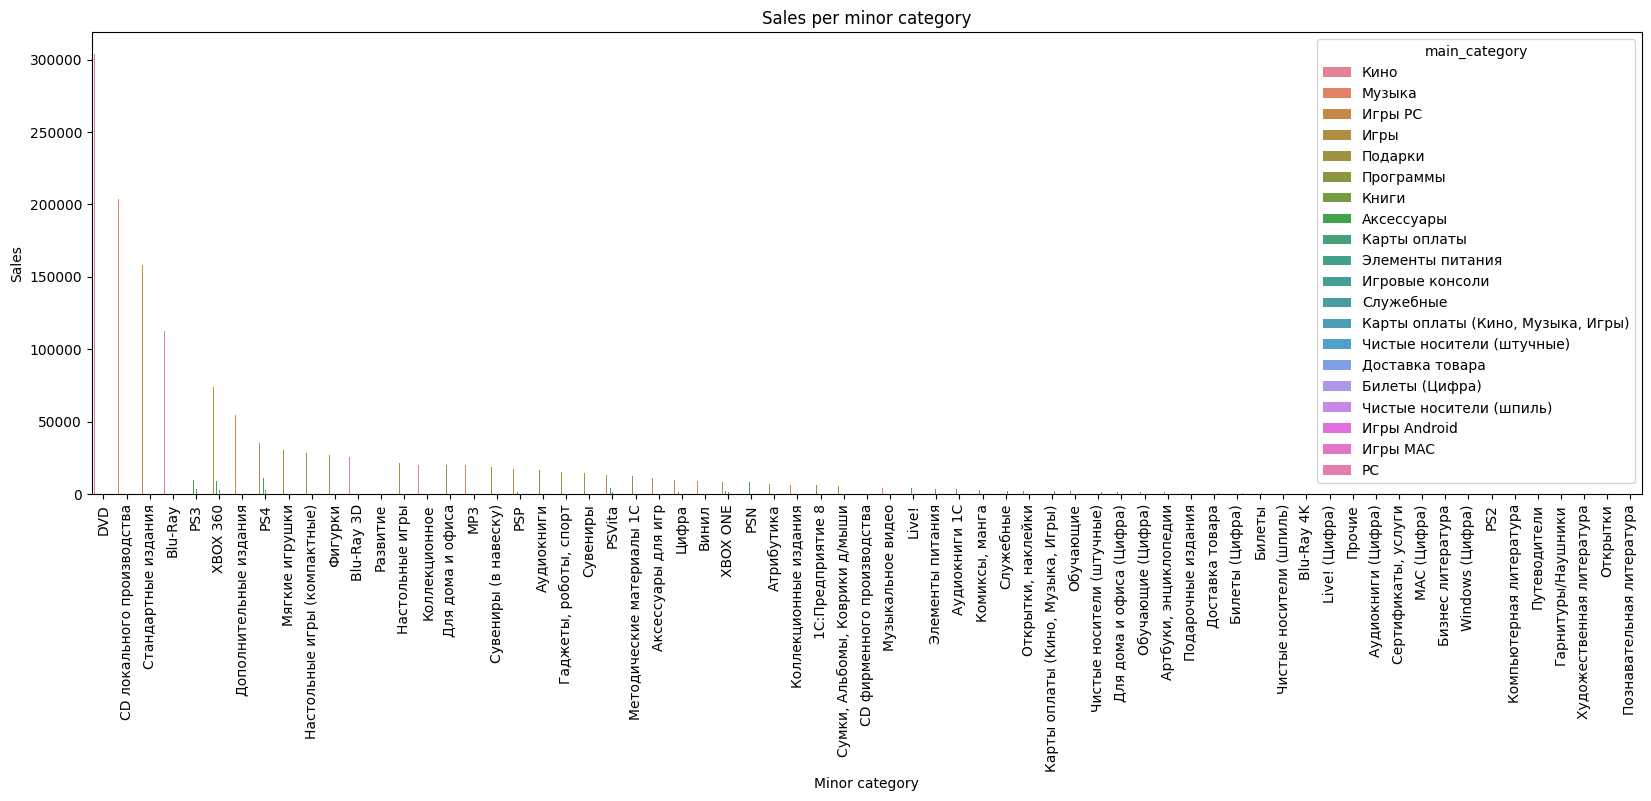

In [100]:
plt.figure(figsize = (20,6))

sns.barplot(data = sorted_group, x = 'minor_category', y = 'item_cnt_month_log', hue = 'main_category')

plt.title('Sales per minor category')
plt.xlabel('Minor category')
plt.ylabel('Sales')

plt.xticks(rotation=90)
plt.show()

Plot of 15th most and minor popular subcategories slice -to get more interpritable picture

In [110]:
len(sorted_group)

84

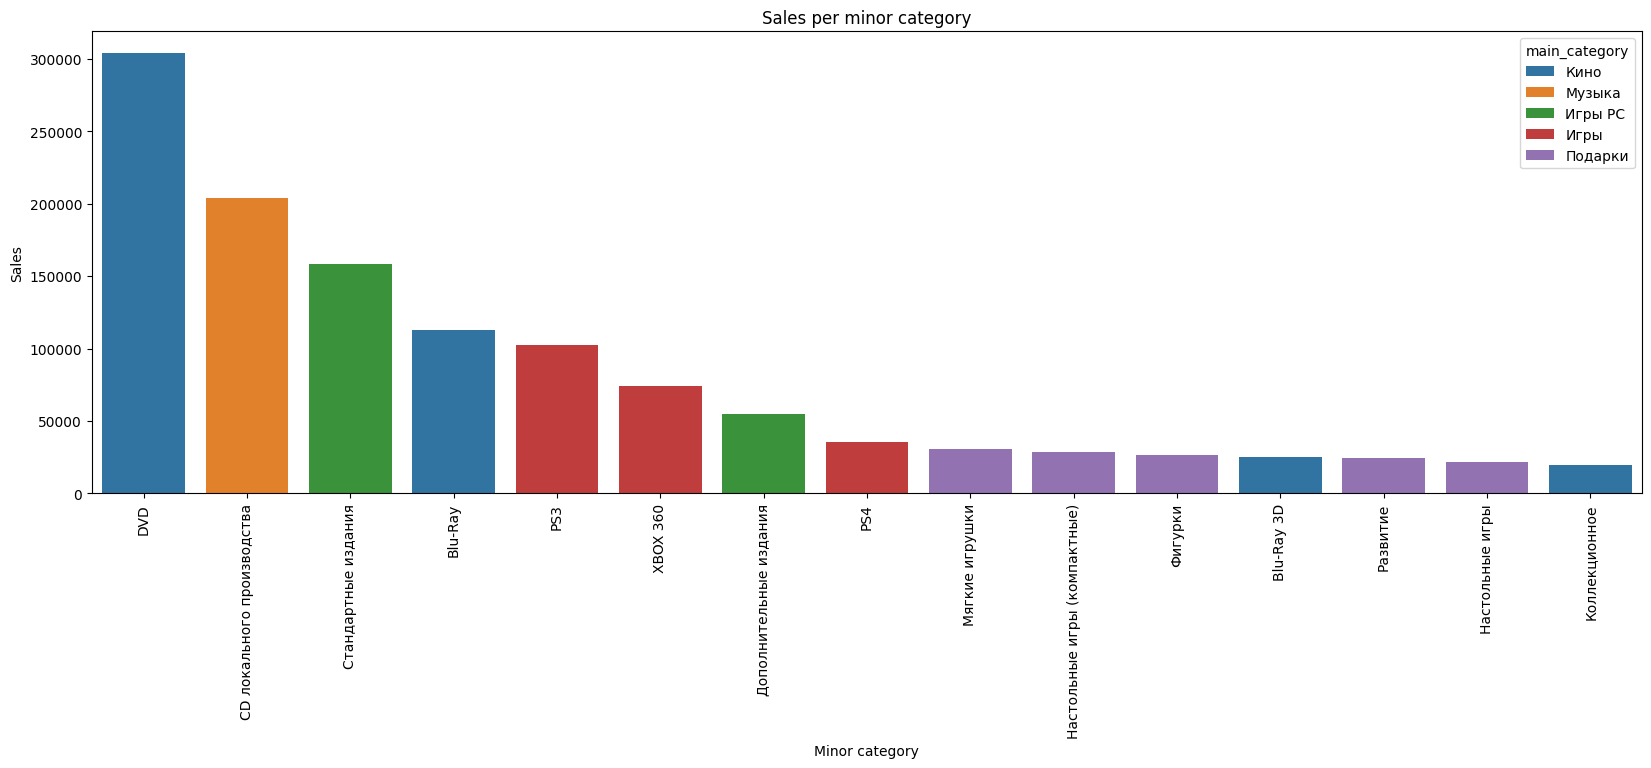

In [111]:
plt.figure(figsize = (20,6))

sns.barplot(data = sorted_group[:15], x = 'minor_category', y = 'item_cnt_month_log', hue = 'main_category')

plt.title('Sales per minor category')
plt.xlabel('Minor category')
plt.ylabel('Sales')

plt.xticks(rotation=90)
plt.show()

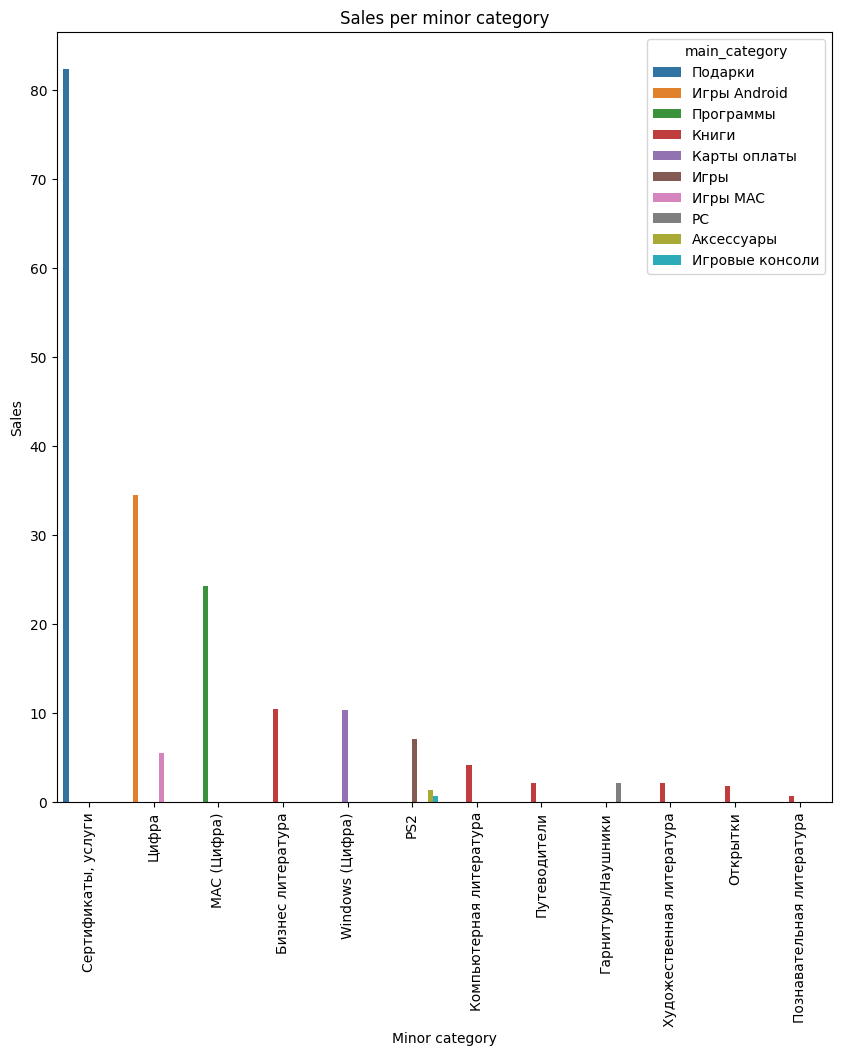

In [114]:
plt.figure(figsize = (10,10))

sns.barplot(data = sorted_group[69:], x = 'minor_category', y = 'item_cnt_month_log', hue = 'main_category')

plt.title('Sales per minor category')
plt.xlabel('Minor category')
plt.ylabel('Sales')

plt.xticks(rotation=90)
plt.show()

The largest sales for main category 'Кино' in DVD format, while Blu-Ray will have smaller sales. We do not see the sales of products from the 'Кино' category in less preffered segment. 
Music sold on CDs is the second most popular among consumers. 'Игры' also fall into the most popular categories, top sales for PC-стандартные издания, PS3 and XBOX-360. 

The slice with the lowest sales included printed products from the category 'Книги'. Category 'Игры' is very popular among customers, although games sold for PS2 are less preferred

In [115]:
category_set = df_item_categories[['item_category_id', 'main_category_id', 'minor_category_id']]
df_train = pd.merge(category_set, df_train, on = 'item_category_id', how = 'left')
df_train.head()

,item_category_id,main_category_id,minor_category_id,date_block_num,shop_id,item_id,item_cnt_month,item_price,item_cnt_month_log,item_price_log,month,year,shop_id_encoded,city_id,revenue_log
0,0,0,31,0,2,16255,0.0,0.0,0.0,0.0,1,2013,0,29,0.0
1,0,0,31,0,2,16256,0.0,0.0,0.0,0.0,1,2013,0,29,0.0
2,0,0,31,0,2,16257,0.0,0.0,0.0,0.0,1,2013,0,29,0.0
3,0,0,31,0,3,16255,0.0,0.0,0.0,0.0,1,2013,1,29,0.0
4,0,0,31,0,3,16256,0.0,0.0,0.0,0.0,1,2013,1,29,0.0


Time tendencies for main category

In [116]:
samples = df_train.main_category_id.sample(3).values

Full-time period

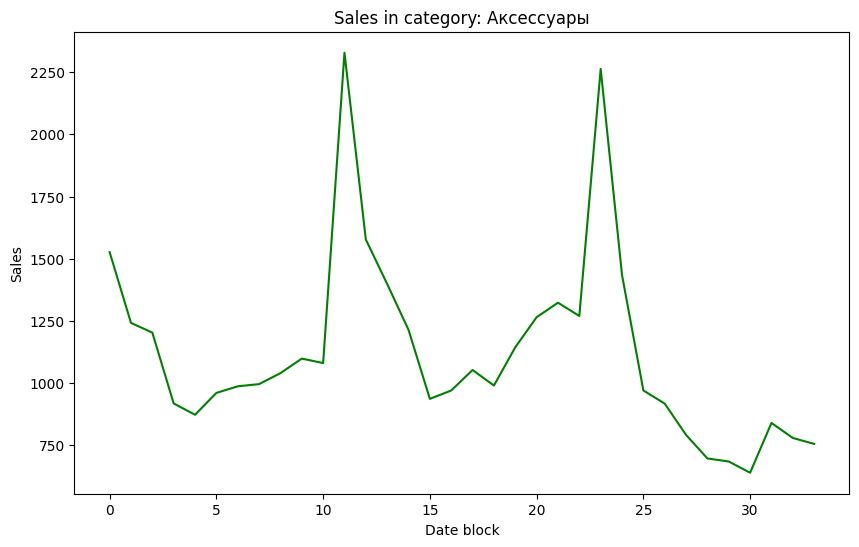

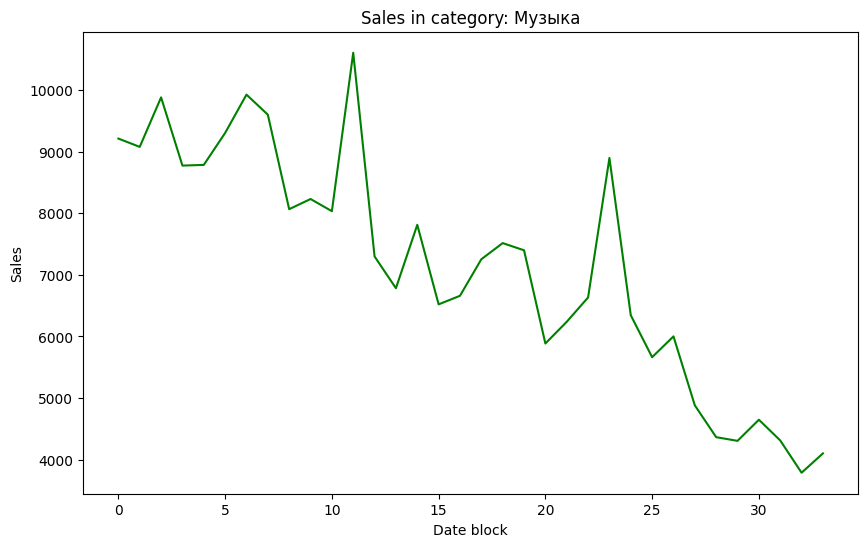

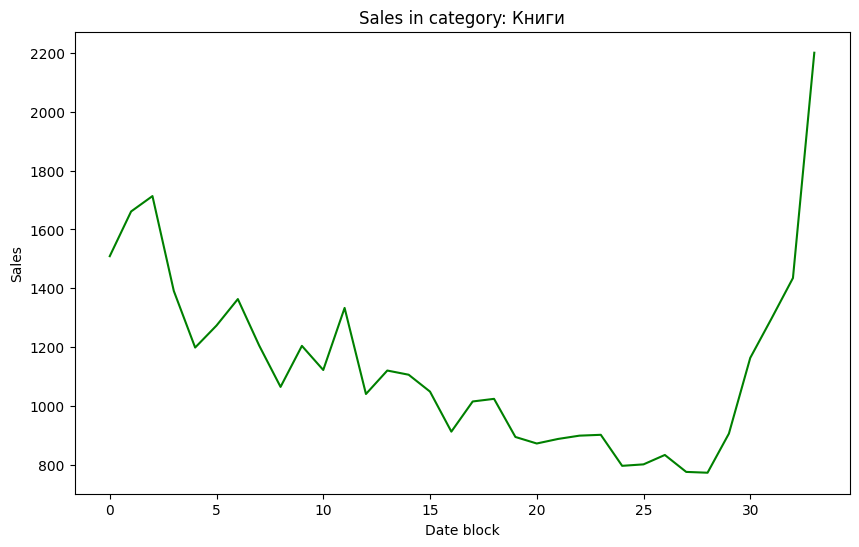

In [118]:
for s in samples:
    plt.figure(figsize = (10,6))

    sns.lineplot(data = df_train.loc[(df_train['main_category_id'] == s) & (df_train.date_block_num < 34)].groupby('date_block_num').agg({'item_cnt_month_log': 'sum'}), x = 'date_block_num', y = 'item_cnt_month_log', c = 'g')
    plt.title(f'Sales in category: {df_item_categories[df_item_categories.main_category_id == s]['main_category'].values[0]}')
    plt.xlabel('Date block')
    plt.ylabel('Sales')
    plt.show()

Each category has its own characteristic time trend. According to the general picture - sales are declining over a full period. For Category 'Книги' we see the opposite - but due to the small contribution of this category to overall sales, they do not change the general trend. For some categories we have seasonal changes - as for category 'Аксессуары'

Tendencies during the year

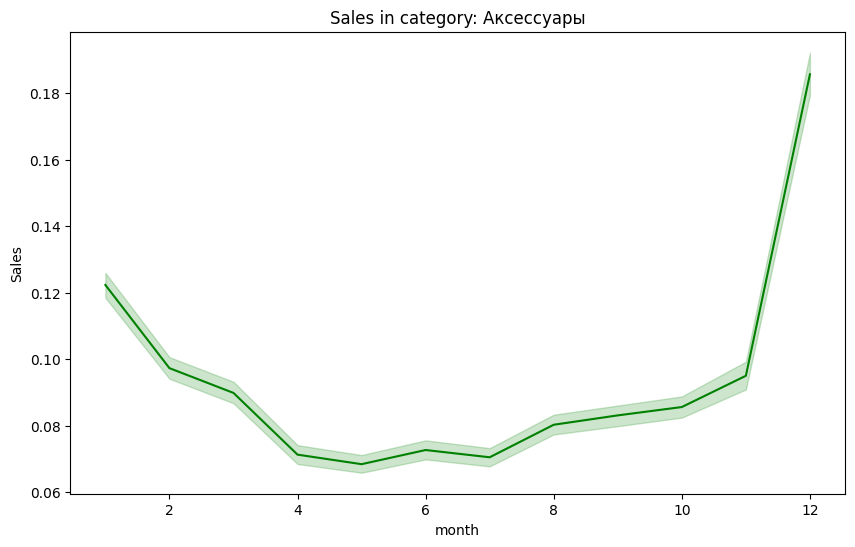

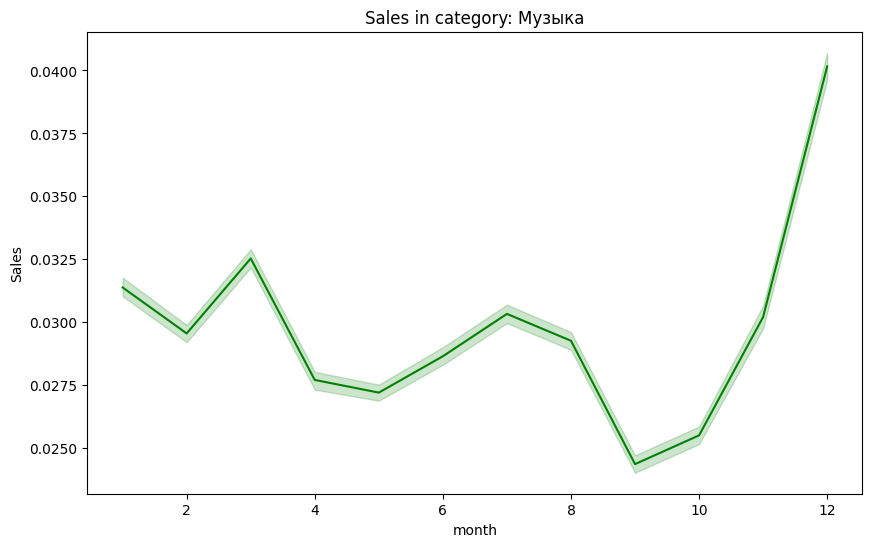

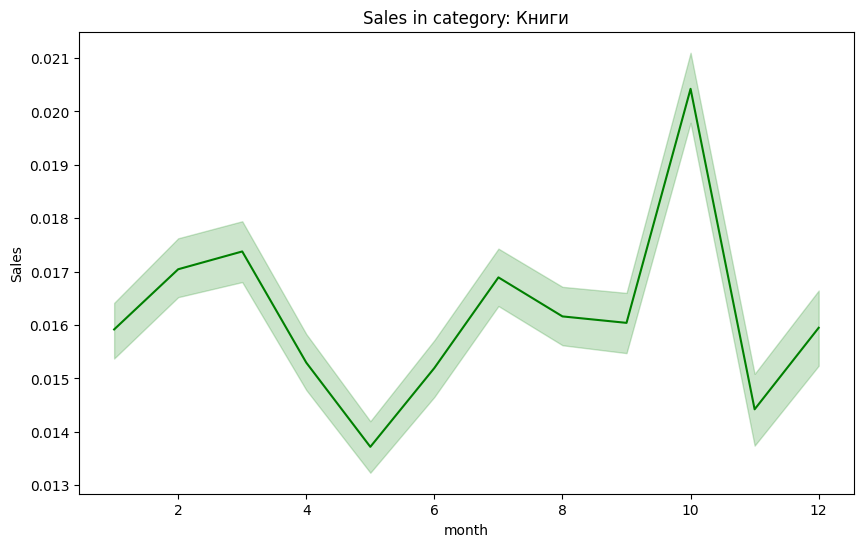

In [120]:
for s in samples:
    plt.figure(figsize = (10,6))

    sns.lineplot(data = df_train.loc[(df_train['main_category_id'] == s) & (df_train.date_block_num < 34)], x = 'month', y = 'item_cnt_month_log', c = 'g')
    plt.title(f'Sales in category: {df_item_categories[df_item_categories.main_category_id == s]['main_category'].values[0]}')
    plt.xlabel('month')
    plt.ylabel('Sales')
    plt.show()

Trend for category 'Книги' differs from others (They are not so much influenced by month). But for the most categories we see increase in sales towards the end of the year.

Time-dependencies for minor-category

In [126]:
samples = df_train.minor_category_id.sample(3).values

For full-rime period

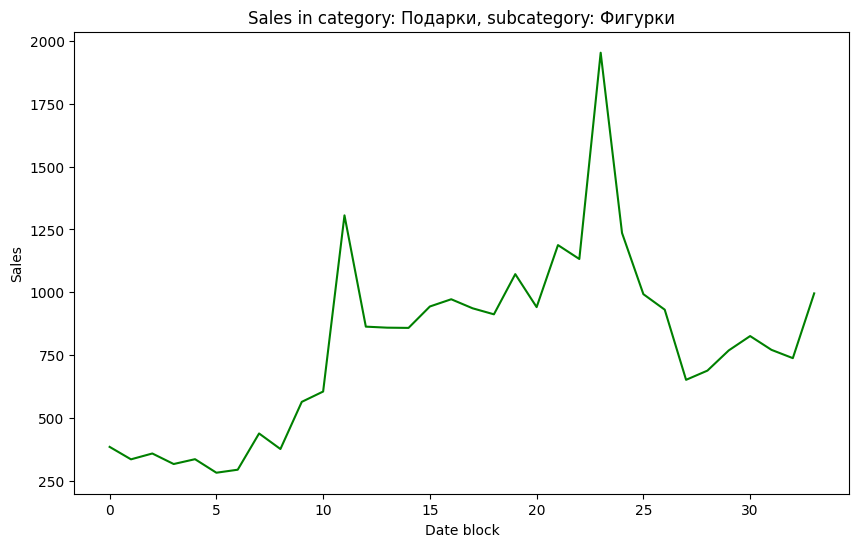

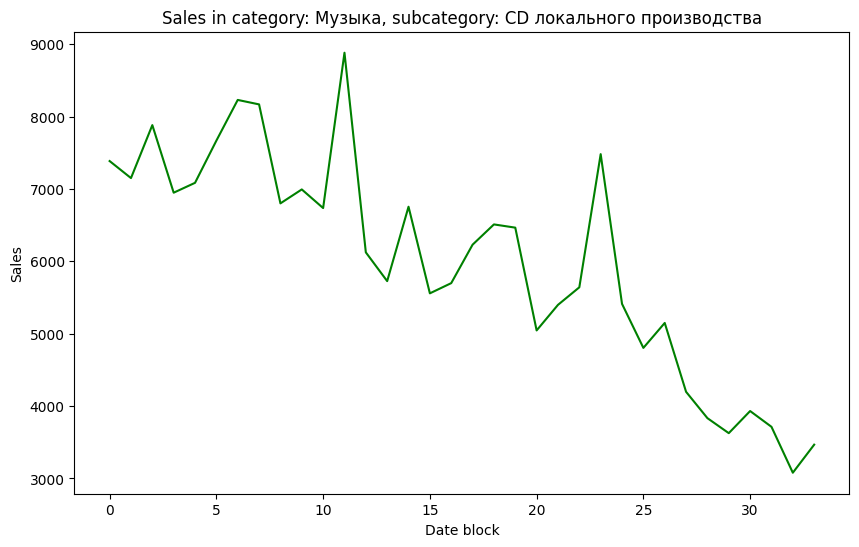

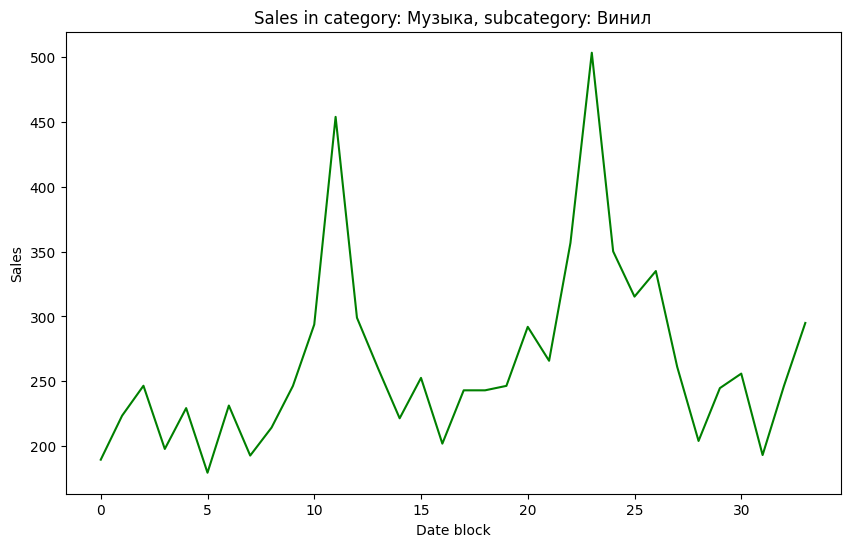

In [127]:
for s in samples:
    plt.figure(figsize = (10,6))

    sns.lineplot(data = df_train.loc[(df_train['minor_category_id'] == s) & (df_train.date_block_num < 34)].groupby('date_block_num').agg({'item_cnt_month_log': 'sum'}), x = 'date_block_num', y = 'item_cnt_month_log', c = 'g')
    plt.title(f'Sales in category: {df_item_categories[df_item_categories.minor_category_id == s]['main_category'].values[0]}, subcategory: {df_item_categories[df_item_categories.minor_category_id == s]['minor_category'].values[0]}')
    plt.xlabel('Date block')
    plt.ylabel('Sales')
    plt.show()

For all subcategories we see seasonality. Changes during the full-period are differ. Sales for the subcategory 'DVD' are decline, due to the declining of hard copies popularity. Some categories are less sensible for time: music on vinyl not losing it's popularity through time.

Correlation

In [67]:
df_train.columns

Index(['item_category_id', 'main_category_id', 'minor_category_id',
       'date_block_num', 'shop_id', 'item_id', 'item_cnt_month', 'item_price',
       'item_cnt_month_log', 'item_price_log', 'month', 'year',
       'shop_id_encoded', 'city_id', 'revenue_log'],
      dtype='object')

In [25]:
categorical = ['date_block_num', 'shop_id_encoded', 'item_id', 'item_category_id',
              'main_category_id', 'minor_category_id', 'city_id', 'month', 'year']

numerical = ['revenue_log', 'item_price_log']

target = ['item_cnt_month']

In [66]:
columns, correlations = [], []

for col in numerical:
    columns.append(col)
    correlations.append(stats.spearmanr(df_train[col], df_train['item_cnt_month_log'])[0])

num_corr = pd.DataFrame({'column': columns, 'correlation': correlations})

num_corr.style.background_gradient()

,column,correlation
0,revenue_log,0.999810
1,item_price_log,0.998795


In [69]:
for category in categorical:
    correlation_ratio(df_train['item_cnt_month_log'], df_train[category], category)

Correlation between sales and date_block_num
Eta_squared: 0.0015
Eta: 0.0389
Correlation between sales and shop_id_encoded
Eta_squared: 0.0007
Eta: 0.0269
Correlation between sales and item_id
Eta_squared: 0.0006
Eta: 0.0253
Correlation between sales and item_category_id
Eta_squared: 0.0042
Eta: 0.0644
Correlation between sales and main_category_id
Eta_squared: 0.0054
Eta: 0.0736
Correlation between sales and minor_category_id
Eta_squared: 0.0019
Eta: 0.0432
Correlation between sales and city_id
Eta_squared: 0.0004
Eta: 0.0202
Correlation between sales and month
Eta_squared: 0.0001
Eta: 0.0081
Correlation between sales and year
Eta_squared: 0.0015
Eta: 0.0384


In [26]:
data = df_train[['item_category_id', 'main_category_id', 'minor_category_id',
       'date_block_num', 'item_id','item_cnt_month_log', 'item_price_log', 'month', 'year',
       'shop_id_encoded', 'city_id', 'revenue_log']]

In [27]:
to_csv(data, 'data.csv')

In [3]:
data = load('data.csv')

Adding more time-dependent features

In [ ]:
group = data.sort_values(by=['date_block_num', 'shop_id_encoded', 'item_id'])
for lag in [1, 2, 3, 6, 12]:
    data[f'item_cnt_month_lag_{lag}'] = (
        group
        .groupby(['date_block_num', 'shop_id_encoded', 'item_id'])['item_cnt_month_log']
        .shift(lag)
    )

In [19]:
data = data.fillna(0)

In [20]:
data.head(2)

,item_category_id,main_category_id,minor_category_id,date_block_num,item_id,item_cnt_month_log,item_price_log,month,year,shop_id_encoded,city_id,revenue_log,item_cnt_month_log_1,item_cnt_month_log_2,item_cnt_month_log_3,item_cnt_month_log_6,item_cnt_month_log_12
0,0,0,31,0,16255,0.0,0.0,1,2013,0,29,0.0,0.0,0.0,0.0,0.0,0.0
1,0,0,31,0,16256,0.0,0.0,1,2013,0,29,0.0,0.0,0.0,0.0,0.0,0.0


In [24]:
to_csv(data, 'data.csv')